In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import gzip
import os

# Definitions

In [2]:
def load_dataframe(jsonfile):
    if jsonfile.endswith(".gz"):
        open_fn = gzip.open
    else:
        open_fn = open
    with open_fn(jsonfile) as f:
        data = json.load(f)
    stuff = data["results"][0]["series"][0]
    df = pd.DataFrame(stuff["values"], columns=stuff["columns"])
    df["time"] = pd.to_datetime(df["time"]).round("min")
    non_categorical = [
        "time",
        "HS06_benchmark",
        "federation_HS06_pledge",
        "jobs",
    ]
    for col in list(df.columns):
        if col in non_categorical:
            continue
        df[col] = df[col].astype("category")
    return df

In [3]:
def load_many(jsonfiles):
    dfs = []
    for filename in jsonfiles:
        print("Loading", filename)
        try:
            dfs.append(load_dataframe(filename))
        except:
            print("Skipping", filename, "because probably empty")
    df = pd.concat(dfs)
    for k, dtype in df.dtypes.items():
        if dtype == object:
            df[k] = df[k].astype("category")
    return df

In [4]:
def aggregate_by(df, col, values="jobs", groupby="time"):
    all_index = [c for c in index_cols if c != col]
    if isinstance(groupby, list):
        all_index += groupby
        all_index = set(all_index)
    return df.pivot(
        index=all_index,
        columns=[col],
        values=values
    ).groupby(level=groupby).sum()

In [5]:
def plot_by(df, col, ax=None, values="jobs", **kwargs):
    ax = aggregate_by(df, col, values=values).plot(ax=ax, **kwargs)
    ax.legend(bbox_to_anchor=(1.05, 1))

In [6]:
# columns that uniquely identify an entry
index_cols = ["time", "panda_queue", "resource", "prod_source", "job_status"]

# Load data

In [7]:
base_dir = "/home/nikolai/data/eschanet_qmonit_dump"

`merged.parquet` can also be found here:

https://cernbox.cern.ch/index.php/s/7Zqe1zSvu9YGgAN

It contains all dumps with 10min granularity (6 days)

In [8]:
parquet_path = os.path.join(base_dir, "merged.parquet")
if not os.path.exists(parquet_path):
    df = load_many(glob.glob(os.path.join(base_dir, "*.json*")))
    df.to_parquet(parquet_path)
else:
    df = pd.read_parquet(parquet_path)

In [9]:
# only the last 7 days are with 10min granularity
df = df[df.time >= df.time.max() - pd.Timedelta("7 days")]

In [10]:
sorted(df.columns)

['HS06_benchmark',
 'atlas_site',
 'cloud',
 'container_type',
 'corepower',
 'country',
 'federation',
 'federation_HS06_pledge',
 'frontier',
 'fts_server',
 'harvester',
 'job_status',
 'jobs',
 'nucleus',
 'panda_queue',
 'pilot_manager',
 'pilot_version',
 'pledge_type',
 'prod_source',
 'resource',
 'resource_factor',
 'resource_type',
 'site_state',
 'tier',
 'time',
 'type',
 'workflow']

# Explanation

We look at this data by summing the number of jobs for each value/category of a certain column e.g. "job_status" and grouping by time stamps:

In [11]:
aggregate_by(df, "job_status")

job_status                 activated  assigned  cancelled  closed  defined  \
time                                                                         
2021-02-12 00:00:00+00:00   165274.0    3258.0        0.0    77.0   6225.0   
2021-02-12 00:10:00+00:00   163723.0    2978.0        0.0  1012.0   6350.0   
2021-02-12 00:20:00+00:00   163071.0    3096.0        0.0   120.0   5777.0   
2021-02-12 00:30:00+00:00   163423.0    2573.0        2.0   239.0   5654.0   
2021-02-12 00:40:00+00:00   162152.0    1983.0        1.0    17.0   5529.0   
...                              ...       ...        ...     ...      ...   
2021-02-18 23:10:00+00:00   151798.0    5235.0       99.0     7.0   6145.0   
2021-02-18 23:20:00+00:00   150079.0    6685.0       39.0     6.0   8143.0   
2021-02-18 23:30:00+00:00   148985.0    6660.0       97.0   984.0   8740.0   
2021-02-18 23:40:00+00:00   147700.0    7337.0       21.0     5.0   9735.0   
2021-02-18 23:50:00+00:00   149086.0    7391.0       29.0     3.0   8251.0   

job_status                 failed  finished  holding  merging   running  \
time                                                                      
2021-02-12 00:00:00+00:00   462.0    3538.0   3124.0  55624.0  146688.0   
2021-02-12 00:10:00+00:00   654.0    4135.0   2856.0  55115.0  147296.0   
2021-02-12 00:20:00+00:00   641.0    6959.0   3257.0  55373.0  146578.0   
2021-02-12 00:30:00+00:00   637.0    7495.0   2450.0  55195.0  145535.0   
2021-02-12 00:40:00+00:00   456.0    5109.0   2701.0  54015.0  145920.0   
...                           ...       ...      ...      ...       ...   
2021-02-18 23:10:00+00:00  1034.0    5736.0   3391.0  30507.0  146266.0   
2021-02-18 23:20:00+00:00   311.0    4442.0   3212.0  30598.0  146046.0   
2021-02-18 23:30:00+00:00   598.0    4200.0   3636.0  30457.0  145968.0   
2021-02-18 23:40:00+00:00   467.0    6893.0   4996.0  30271.0  145723.0   
2021-02-18 23:50:00+00:00  1043.0    8438.0   4145.0  29924.0  145388.0   

job_status                  sent  starting  throttled  transferring  
time                                                                 
2021-02-12 00:00:00+00:00  105.0   34912.0        0.0       23881.0  
2021-02-12 00:10:00+00:00   31.0   34851.0        0.0       25717.0  
2021-02-12 00:20:00+00:00   22.0   34723.0        0.0       23598.0  
2021-02-12 00:30:00+00:00   36.0   34916.0        0.0       21579.0  
2021-02-12 00:40:00+00:00   22.0   34840.0        0.0       23142.0  
...                          ...       ...        ...           ...  
2021-02-18 23:10:00+00:00   37.0   32295.0      368.0       44498.0  
2021-02-18 23:20:00+00:00   36.0   32250.0      368.0       46291.0  
2021-02-18 23:30:00+00:00   20.0   31974.0      368.0       47722.0  
2021-02-18 23:40:00+00:00   92.0   31899.0      368.0       46094.0  
2021-02-18 23:50:00+00:00   81.0   31292.0      368.0       45561.0  

[990 rows x 14 columns]

In addition to the timestamp, we can also group by other fields, for example we can do this for each "panda_queue":

In [12]:
aggregate_by(df, "job_status", groupby=["panda_queue", "time"])

job_status                                           activated  assigned  \
panda_queue               time                                             
AGLT2                     2021-02-12 00:00:00+00:00     3166.0      28.0   
                          2021-02-12 00:10:00+00:00     2850.0      27.0   
                          2021-02-12 00:20:00+00:00     2818.0      53.0   
                          2021-02-12 00:30:00+00:00     2775.0     127.0   
                          2021-02-12 00:40:00+00:00     2750.0      67.0   
...                                                        ...       ...   
wuppertalprod_CONDOR_TEST 2021-02-18 23:10:00+00:00        0.0       0.0   
                          2021-02-18 23:20:00+00:00        0.0       0.0   
                          2021-02-18 23:30:00+00:00        0.0       0.0   
                          2021-02-18 23:40:00+00:00        0.0       0.0   
                          2021-02-18 23:50:00+00:00        0.0       0.0   

job_status                                           cancelled  closed  \
panda_queue               time                                           
AGLT2                     2021-02-12 00:00:00+00:00        0.0     0.0   
                          2021-02-12 00:10:00+00:00        0.0     2.0   
                          2021-02-12 00:20:00+00:00        0.0     0.0   
                          2021-02-12 00:30:00+00:00        0.0     0.0   
                          2021-02-12 00:40:00+00:00        0.0     0.0   
...                                                        ...     ...   
wuppertalprod_CONDOR_TEST 2021-02-18 23:10:00+00:00        0.0     0.0   
                          2021-02-18 23:20:00+00:00        0.0     0.0   
                          2021-02-18 23:30:00+00:00        0.0     0.0   
                          2021-02-18 23:40:00+00:00        0.0     0.0   
                          2021-02-18 23:50:00+00:00        0.0     0.0   

job_status                                           defined  failed  \
panda_queue               time                                         
AGLT2                     2021-02-12 00:00:00+00:00    130.0    11.0   
                          2021-02-12 00:10:00+00:00    159.0     9.0   
                          2021-02-12 00:20:00+00:00    212.0    16.0   
                          2021-02-12 00:30:00+00:00    180.0     3.0   
                          2021-02-12 00:40:00+00:00    157.0     0.0   
...                                                      ...     ...   
wuppertalprod_CONDOR_TEST 2021-02-18 23:10:00+00:00      0.0     8.0   
                          2021-02-18 23:20:00+00:00      0.0     8.0   
                          2021-02-18 23:30:00+00:00      0.0     8.0   
                          2021-02-18 23:40:00+00:00      0.0    10.0   
                          2021-02-18 23:50:00+00:00      0.0     6.0   

job_status                                           finished  holding  \
panda_queue               time                                           
AGLT2                     2021-02-12 00:00:00+00:00      61.0     45.0   
                          2021-02-12 00:10:00+00:00      53.0     40.0   
                          2021-02-12 00:20:00+00:00      76.0     56.0   
                          2021-02-12 00:30:00+00:00     162.0     56.0   
                          2021-02-12 00:40:00+00:00      81.0     69.0   
...                                                       ...      ...   
wuppertalprod_CONDOR_TEST 2021-02-18 23:10:00+00:00       0.0      0.0   
                          2021-02-18 23:20:00+00:00       0.0      0.0   
                          2021-02-18 23:30:00+00:00       0.0      0.0   
                          2021-02-18 23:40:00+00:00       0.0      0.0   
                          2021-02-18 23:50:00+00:00       0.0      0.0   

job_status                                           merging  running  sent  \
panda_queue               time                                       

# Make some plots similar to Dashboard

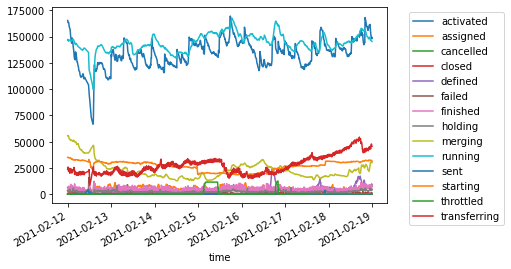

In [13]:
plot_by(df, "job_status")

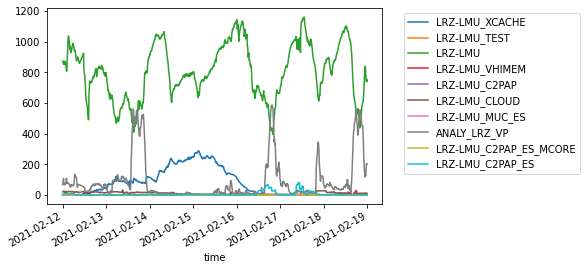

In [14]:
plot_by(df[(df.atlas_site == "LRZ-LMU") & (df.job_status == "running")], "panda_queue")

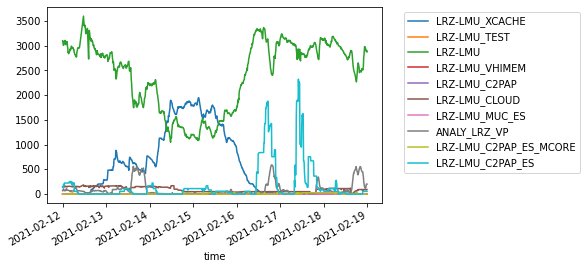

In [15]:
plot_by(
    df[(df.atlas_site == "LRZ-LMU") & (df.job_status == "running")]
    .assign(slots=lambda x: x.jobs * x.resource_factor),
    "panda_queue",
    values="slots"
)

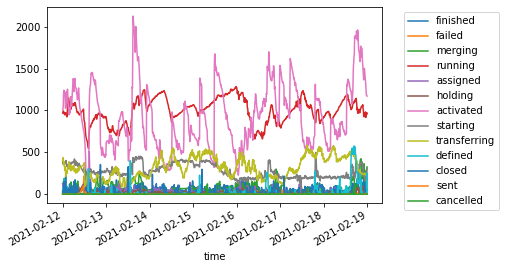

In [16]:
plot_by(df[df.atlas_site == "LRZ-LMU"], "job_status")

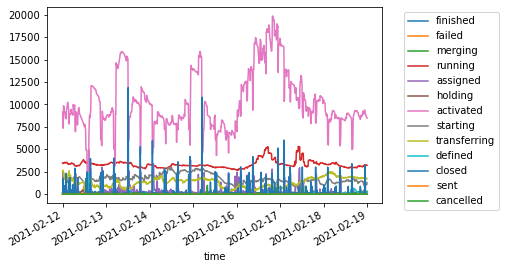

In [17]:
plot_by(
    df[df.atlas_site == "LRZ-LMU"].assign(slots=lambda x: x.jobs * x.resource_factor),
    "job_status",
    values="slots"
)

# Look at suspicious drops in running jobs (or increase in failed)

In [18]:
def get_suspicious(
    df,
    job_status="running",
    ratio_filter=lambda ratio: ratio < 0.1,
    what="panda_queue"
):
    df_job_status = aggregate_by(
        df[(df.job_status == job_status)],
        "job_status",
        groupby=[what, "time"]
    )
    df_job_status.columns = [job_status]
    df_ratio = df_job_status / pd.concat(
        group.rolling("24h", on=group.index.get_level_values("time")).mean()
        for k, group in
        df_job_status.groupby(what)
    )
    df_job_status["suspicious"] = ratio_filter(df_ratio[job_status])
    return df_job_status.reset_index().pivot(
        index=[what, "time"], columns=["suspicious"], values=job_status
    )

In [19]:
def plot_random(by_sus, what="panda_queue"):
    is_sus = np.isnan(by_sus[False]).groupby(what).any()
    random_queues = np.random.permutation(
        is_sus[is_sus].reset_index()[what].to_numpy()
    )
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
    for q, ax in zip(random_queues, np.array(axs).ravel()):
        by_sus.loc[q].plot(ax=ax)
        ax.set_title(q)
    fig.tight_layout()

In [20]:
suspicious_running = get_suspicious(df)

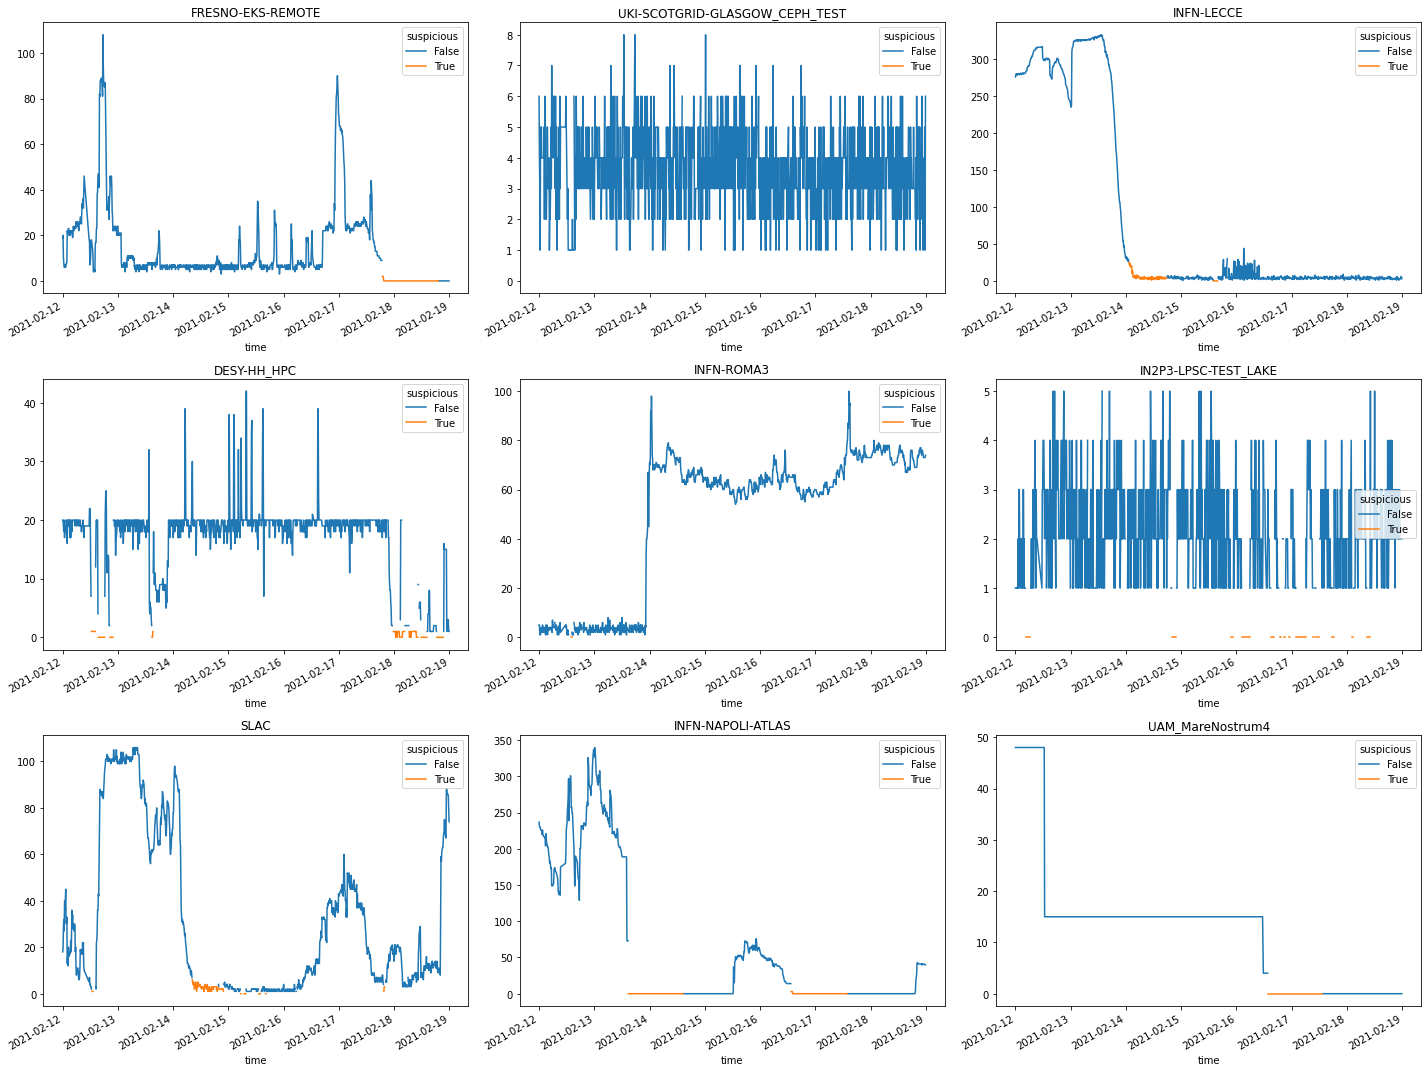

In [21]:
plot_random(suspicious_running)

In [22]:
suspicious_failed = get_suspicious(df, job_status="failed", ratio_filter=lambda ratio: ratio > 10)

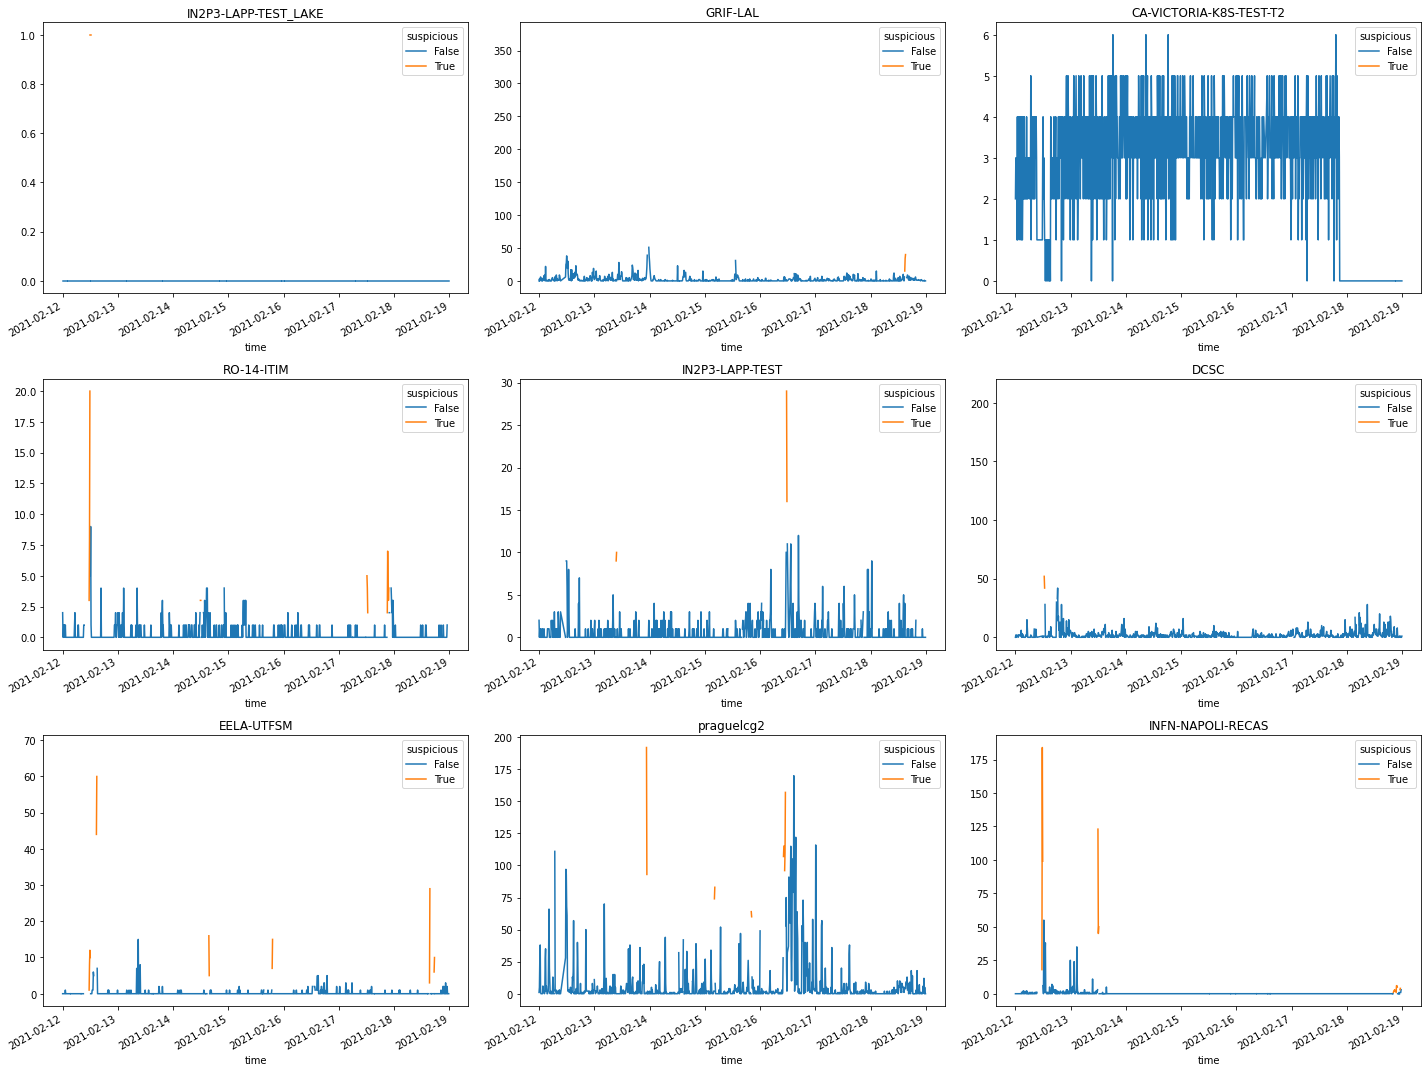

In [23]:
plot_random(suspicious_failed)

In [24]:
suspicious_running_sites = get_suspicious(df, what="atlas_site")

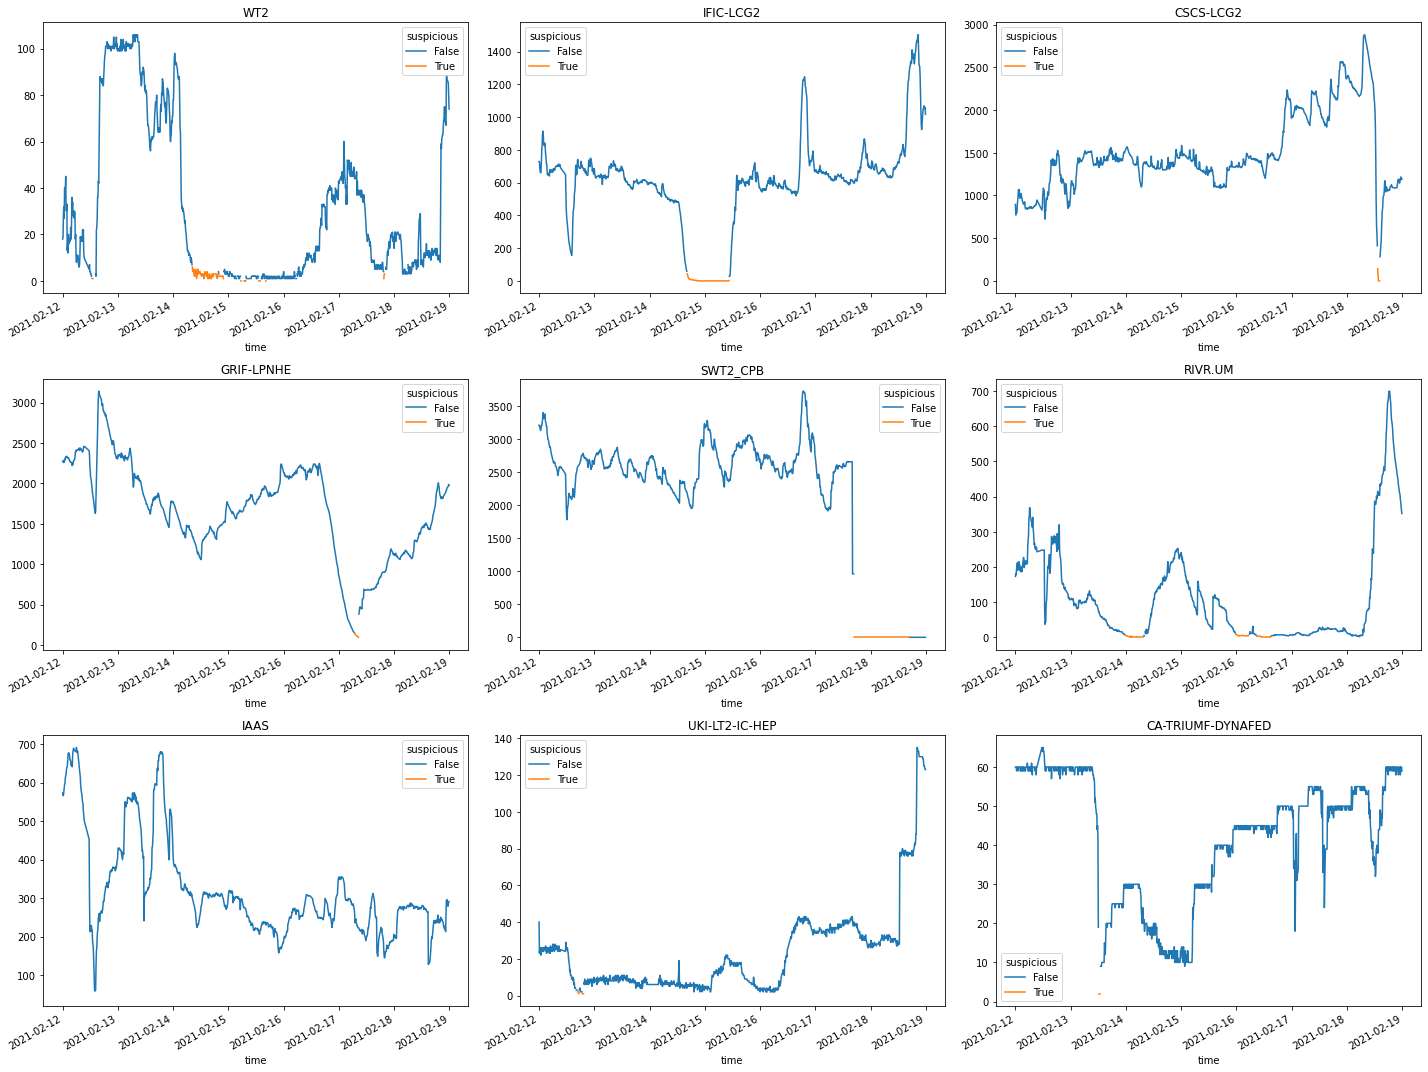

In [25]:
plot_random(suspicious_running_sites, what="atlas_site")

In [26]:
suspicious_cloud = get_suspicious(df, what="cloud", job_status="failed", ratio_filter=lambda ratio: ratio > 5)

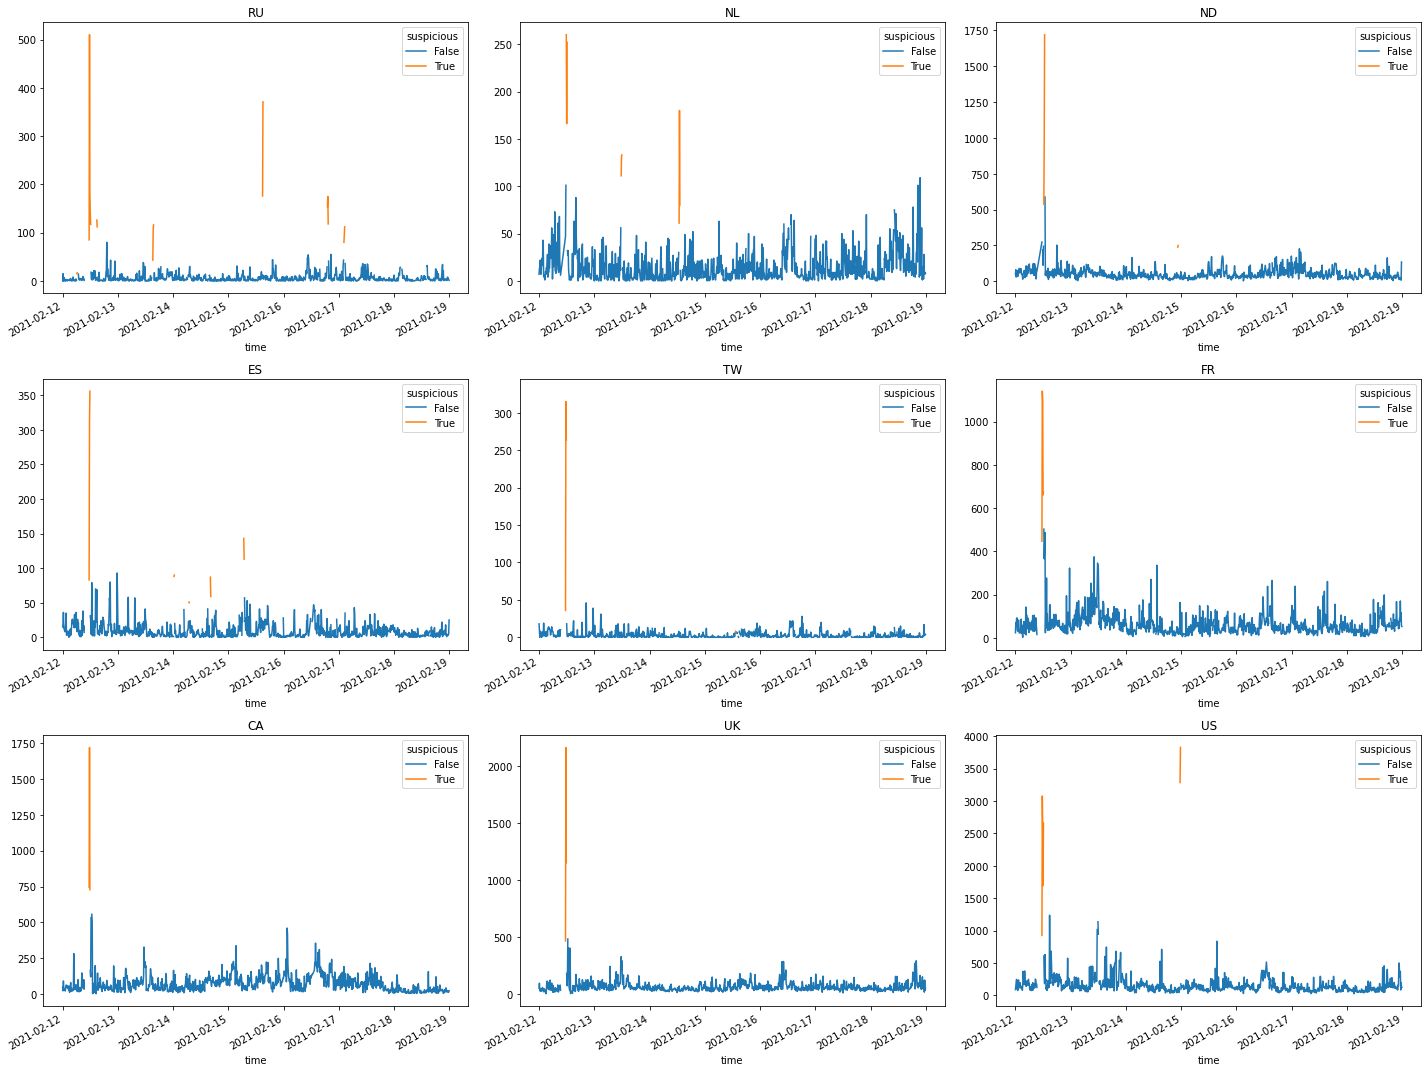

In [27]:
plot_random(suspicious_cloud, what="cloud")